# Выпускной проект - Промышленность

**Заказчик** - металлургический комбинат ООО «Так закаляем сталь»

**Цель** - уменьшение потребления электроэнергии на этапе обработки стали, чтобы оптимизировать производственные расходы 

**Задача** - построить модель, которая предскажет температуру стали


**Процесс обработки стали** - сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**Описание данных** - данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [1]:
# установка библиотеки
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor  
from statsmodels.tools.tools import add_constant 

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

pd.options.mode.chained_assignment = None 

In [ ]:
def main_info (name, df):
    print("\033[1m" + name + "\033[0m")
    display(df.head())
    print()
    print(name + ' размер таблицы данных - ' , df.shape)
    print()
    print(df.info())
    print()
    print('Процент пропущенных значений')
    print(df.isna().mean()*100)
    print()
    display(name + ' описание данных ', df.describe())
    print()
    for col in df.columns:
        print('Количество уникальных значений столбца', "\033[1m"+col+"\033[0m")
        print(df[col].nunique())

In [7]:
! gdown --id 19OMwCMiS874h7ZkLPxm7IXr2Mse-_cGB
! gdown --id 1Y2QvS2JrfD3ttqzQ_lVWsD0V64GdinRr
! gdown --id 1Fk12X5wHL-eLg0TCNivLdPhRayHYoOph
! gdown --id 1tIpFidc_1vcFT3w72dtoiuLhvNf0aJuf
! gdown --id 1nli4FEOkooGZo2xE9BNc2ZE_R3Esrx3w
! gdown --id 1_3D4hpm4fChtNjUPV9IO5y74UYryjS7K
! gdown --id 1OWLqR4fjbsdjX98MXM4hGc32h93-YtVY

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19OMwCMiS874h7ZkLPxm7IXr2Mse-_cGB
To: /content/data_arc.csv
100% 1.10M/1.10M [00:00<00:00, 126MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Y2QvS2JrfD3ttqzQ_lVWsD0V64GdinRr
To: /content/data_bulk.csv
100% 115k/115k [00:00<00:00, 65.0MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id

In [8]:
data_arc = pd.read_csv('/content/data_arc.csv')
data_bulk = pd.read_csv('/content/data_bulk.csv')
data_bulk_time = pd.read_csv('/content/data_bulk_time.csv')
data_gas = pd.read_csv('/content/data_gas.csv')
data_temp = pd.read_csv('/content/data_temp.csv')
data_wire = pd.read_csv('/content/data_wire.csv')
data_wire_time = pd.read_csv('/content/data_wire_time.csv')

## Первичный анализ данных

### Данные об электродах (data_arc)

In [ ]:
main_info ('Данные об электродах', data_arc)

Данные об электродах


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



Данные об электродах размер таблицы данных -  (14876, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

Процент пропущенных значений
key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64



'Данные об электродах описание данных '

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388



Количество уникальных значений столбца key
3214
Количество уникальных значений столбца Начало нагрева дугой
14875
Количество уникальных значений столбца Конец нагрева дугой
14876
Количество уникальных значений столбца Активная мощность
14869
Количество уникальных значений столбца Реактивная мощность
14866


In [ ]:
# удаляем ключ с аномально отрицательным значением реактивной мощности
data_arc = data_arc[data_arc['key']!=2116]

In [ ]:
# создаем столбец с полной мощностью по формуле, агрегировав ключи
data_total = pd.pivot_table(data_arc, index = ['key'], 
                                values = ['Активная мощность', 'Реактивная мощность'], 
                                aggfunc=np.sum).reset_index()
data_total ['Полная мощность'] = np.sqrt(data_total ['Активная мощность'] **2 + 
                                               data_total ['Реактивная мощность'] **2)
data_total.head()

,key,Активная мощность,Реактивная мощность,Полная мощность
0,1,4.878147,3.183241,5.824889
1,2,3.052598,1.998112,3.648398
2,3,2.525882,1.599076,2.989502
3,4,3.209250,2.060298,3.813674
4,5,3.347173,2.252643,4.034596


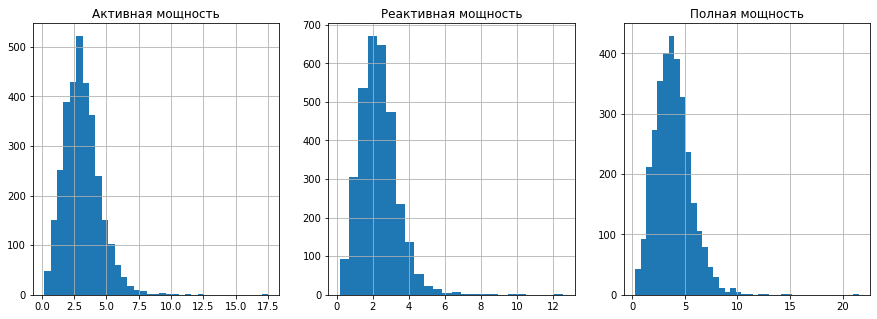

In [ ]:
fig, ax = plt.subplots(1,3,  figsize=(15, 5))

ax[0].hist(x = data_total ['Активная мощность'], bins = 35)
ax[0].set_title('Активная мощность')
ax[0].grid()

ax[1].hist(x = data_total['Реактивная мощность'], bins = 24)
ax[1].set_title('Реактивная мощность')
ax[1].grid()

ax[2].hist(x = data_total['Полная мощность'], bins = 40)
ax[2].set_title('Полная мощность')
ax[2].grid()

Был создан фундамент для итоговой таблицы по ключам, а также добавлен дополнительный признак для обучения - Полная мощность


### Данные о подаче сыпучих материалов (объём) (data_bulk)

In [ ]:
main_info ('Данные о подаче сыпучих материалов (объём)', data_bulk)


Данные о подаче сыпучих материалов (объём)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Данные о подаче сыпучих материалов (объём) размер таблицы данных -  (3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

Процент пропущенных значений
key         0.000000
Bulk 1     91.94630

'Данные о подаче сыпучих материалов (объём) описание данных '

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000



Количество уникальных значений столбца key
3129
Количество уникальных значений столбца Bulk 1
47
Количество уникальных значений столбца Bulk 2
15
Количество уникальных значений столбца Bulk 3
278
Количество уникальных значений столбца Bulk 4
206
Количество уникальных значений столбца Bulk 5
55
Количество уникальных значений столбца Bulk 6
205
Количество уникальных значений столбца Bulk 7
25
Количество уникальных значений столбца Bulk 8
1
Количество уникальных значений столбца Bulk 9
10
Количество уникальных значений столбца Bulk 10
77
Количество уникальных значений столбца Bulk 11
101
Количество уникальных значений столбца Bulk 12
331
Количество уникальных значений столбца Bulk 13
14
Количество уникальных значений столбца Bulk 14
284
Количество уникальных значений столбца Bulk 15
156


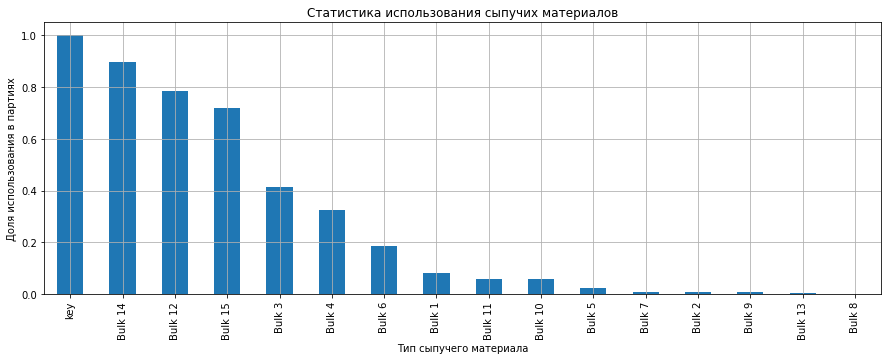

In [ ]:
# узнаем какие типы сыпучего материла чаще добавлялись в смесь
plt.figure(figsize = (15,5))
ax = (~data_bulk.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.grid()
ax.set_title('Статистика использования сыпучих материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип сыпучего материала');

В более половины партий добавлялись материалы - 14, 12, 15

In [ ]:
# заменяем пропуски на 0, объединяем с финальной таблицей
data_bulk = data_bulk.fillna(0)
data_total = data_total.merge(data_bulk, how = 'inner', on ='key')

### Данные о подаче сыпучих материалов (время) (data_bulk_time)

In [ ]:
main_info ('Данные о подаче сыпучих материалов (время)', data_bulk_time)

Данные о подаче сыпучих материалов (время)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56



Данные о подаче сыпучих материалов (время) размер таблицы данных -  (3129, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

Процент пропущенных значений
key         0.000000
Bulk 1     91.946309
Bulk 2     99.29

'Данные о подаче сыпучих материалов (время) описание данных '

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000



Количество уникальных значений столбца key
3129
Количество уникальных значений столбца Bulk 1
252
Количество уникальных значений столбца Bulk 2
22
Количество уникальных значений столбца Bulk 3
1298
Количество уникальных значений столбца Bulk 4
1014
Количество уникальных значений столбца Bulk 5
77
Количество уникальных значений столбца Bulk 6
576
Количество уникальных значений столбца Bulk 7
25
Количество уникальных значений столбца Bulk 8
1
Количество уникальных значений столбца Bulk 9
19
Количество уникальных значений столбца Bulk 10
176
Количество уникальных значений столбца Bulk 11
177
Количество уникальных значений столбца Bulk 12
2450
Количество уникальных значений столбца Bulk 13
18
Количество уникальных значений столбца Bulk 14
2806
Количество уникальных значений столбца Bulk 15
2248


Таблица со временем не пригодится для дальнейшего обучения модели

### Данные о продувке сплава газом (data_gas)

In [ ]:
main_info ('Данные о продувке сплава газом', data_gas)

Данные о продувке сплава газом


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Данные о продувке сплава газом размер таблицы данных -  (3239, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

Процент пропущенных значений
key      0.0
Газ 1    0.0
dtype: float64



'Данные о продувке сплава газом описание данных '

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040



Количество уникальных значений столбца key
3239
Количество уникальных значений столбца Газ 1
3239


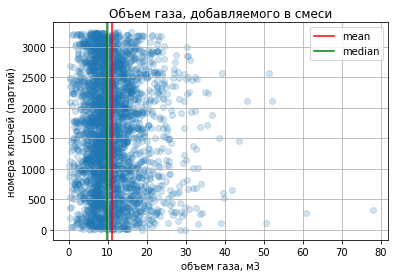

In [ ]:
plt.scatter(x= data_gas['Газ 1'], y = data_gas['key'], alpha = 0.2);
plt.grid()
plt.title('Объем газа, добавляемого в смеси')
plt.xlabel('объем газа, м3')
plt.ylabel('номера ключей (партий)')
plt.axvline(x=data_gas['Газ 1'].mean(), color='r', linestyle='-', label ='mean')
plt.axvline(x=data_gas['Газ 1'].median(), color='g', linestyle='-', label ='median')
plt.legend()
plt.show()


В среднем объем добавляемого в смесь газа равен 10 м3 и не превышает 30 м3, значений свыше не так много (для этих позиций скорее всего добавляли больше веществ и дольше перемешивали, следовательно больший объем газа затрачен).

In [ ]:
# присоединяем к общей таблице информацию о добавляемом газе
data_total = data_total.merge(data_gas, how = 'inner', on ='key')

### Результаты измерения температуры (data_temp)

In [ ]:
main_info ('Результаты измерения температуры', data_temp)

Результаты измерения температуры


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



Результаты измерения температуры размер таблицы данных -  (15907, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB
None

Процент пропущенных значений
key              0.000000
Время замера     0.000000
Температура     18.237254
dtype: float64



'Результаты измерения температуры описание данных '

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000



Количество уникальных значений столбца key
3216
Количество уникальных значений столбца Время замера
15907
Количество уникальных значений столбца Температура
175


Так как существуют пропуски в целевом показателе, необходимо убрать партии с отсутствующими значениями из обучения модели,  отсутствие целевых данных может исказить обучение

Для начала наайдем эти партии

In [ ]:
data_temp_agg = data_temp.groupby('key').count().reset_index()
data_temp_agg['Процент заполненности целевого показателя'] = (data_temp_agg['Температура']/
                                                              data_temp_agg['Время замера'])*100
data_temp_agg.head()


,key,Время замера,Температура,Процент заполненности целевого показателя
0,1,5,5,100.0
1,2,6,6,100.0
2,3,5,5,100.0
3,4,3,3,100.0
4,5,2,2,100.0


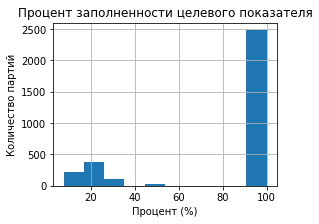

In [ ]:
ax = data_temp_agg['Процент заполненности целевого показателя'].hist(figsize=(4,3))
ax.set_title('Процент заполненности целевого показателя')
ax.set_xlabel('Процент (%)')
ax.set_ylabel('Количество партий');

In [ ]:
# удаляем партии с пропущенными значениями
data_temp_cut = data_temp[data_temp.key.isin(data_temp_agg[data_temp_agg['Процент заполненности целевого показателя'] == 100]
                                             .index.values)]
data_temp_cut.isna().sum()

key             0
Время замера    0
Температура     0
dtype: int64

In [ ]:
# группируем партии, создавая столбец с первым и последним замером температуры
data_temp_gr = data_temp_cut.groupby('key')['Температура'].agg(['first', 'last'])
data_temp_gr = data_temp_gr.reset_index()

In [ ]:
# отбираем целевые значения больше 1500 градусов
data_temp_gr = data_temp_gr[data_temp_gr['first']>=1500]

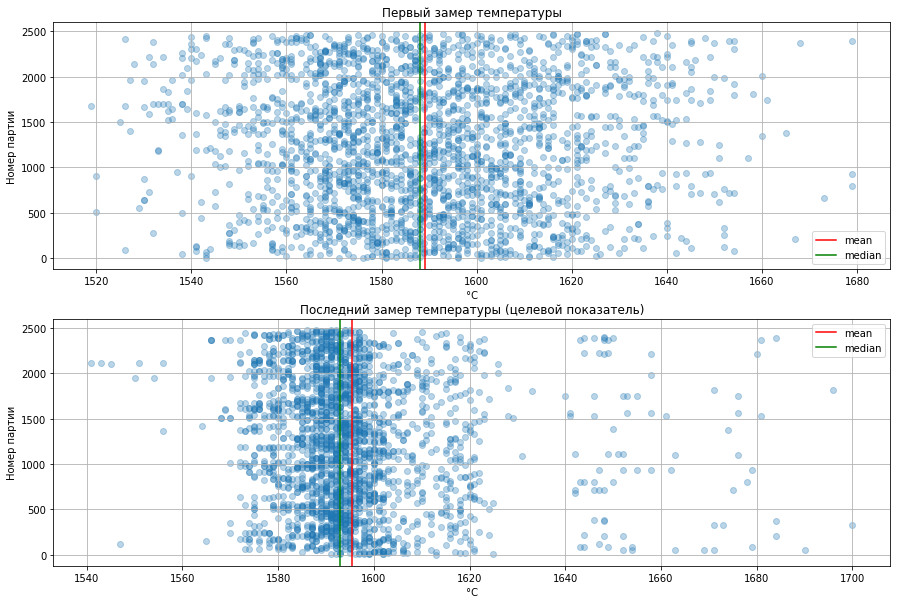

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (15,10))
ax[0].scatter(x = data_temp_gr['first'], y = data_temp_gr['key'],alpha = 0.3)
ax[0].grid()
ax[0].set_title('Первый замер температуры')
ax[0].axvline(x=data_temp_gr['first'].mean(), color='r', linestyle='-', label ='mean')
ax[0].axvline(x=data_temp_gr['first'].median(), color='g', linestyle='-', label ='median')
ax[0].set_xlabel('°C')
ax[0].set_ylabel('Номер партии')
ax[0].legend()

ax[1].scatter(x = data_temp_gr['last'], y = data_temp_gr['key'],alpha = 0.3)
ax[1].grid()
ax[1].set_title('Последний замер температуры (целевой показатель)')
ax[1].axvline(x=data_temp_gr['last'].mean(), color='r', linestyle='-', label ='mean')
ax[1].axvline(x=data_temp_gr['last'].median(), color='g', linestyle='-', label ='median')
ax[1].set_xlabel('°C')
ax[1].set_ylabel('Номер партии')
ax[1].legend();

In [ ]:
# присоединяем к общей таблице информацию о температуре
data_total = data_total.merge(data_temp_gr, how = 'inner', on ='key')

### Данные о проволочных материалах (объём) (data_wire)

In [ ]:
main_info ('Данные о проволочных материалах (объём)', data_wire)

Данные о проволочных материалах (объём)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Данные о проволочных материалах (объём) размер таблицы данных -  (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

Процент пропущенных значений
key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64



'Данные о проволочных материалах (объём) описание данных '

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604



Количество уникальных значений столбца key
3081
Количество уникальных значений столбца Wire 1
2251
Количество уникальных значений столбца Wire 2
713
Количество уникальных значений столбца Wire 3
56
Количество уникальных значений столбца Wire 4
14
Количество уникальных значений столбца Wire 5
1
Количество уникальных значений столбца Wire 6
69
Количество уникальных значений столбца Wire 7
10
Количество уникальных значений столбца Wire 8
13
Количество уникальных значений столбца Wire 9
25


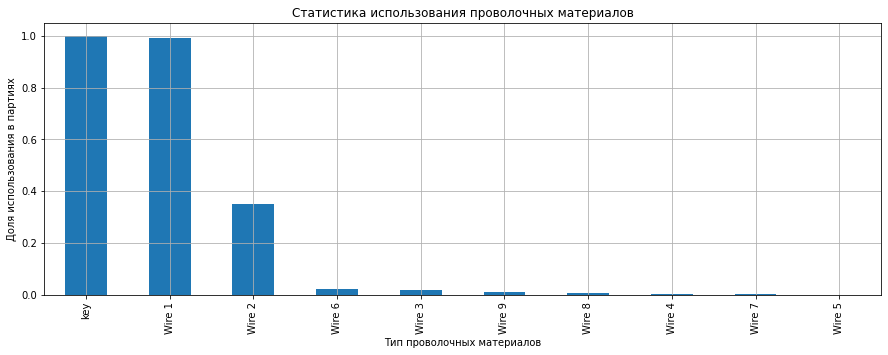

In [ ]:
# узнаем какие типы проволочных материалов применялись
plt.figure(figsize = (15,5))
ax = (~data_wire.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar')
ax.grid()
ax.set_title('Статистика использования проволочных материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Тип проволочных материалов');

Почти в 100% партий присутствовал первый тип проволочных материалов, оставшиеся же приемнялись крайне редко, кроме второго типа, который был применен в 37% партий

In [ ]:
# присоединяем к общей таблице информацию о проволочных материалах
data_wire = data_wire.fillna(0)
data_total = data_total.merge(data_wire, how = 'inner', on ='key')

### Данные о проволочных материалах (время) (data_wire_time)

In [ ]:
main_info ('Данные о проволочных материалах (время)', data_wire_time)

Данные о проволочных материалах (время)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Данные о проволочных материалах (время) размер таблицы данных -  (3081, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

Процент пропущенных значений
key        0.000000
Wire 1     0.843882
Wire 2    64.978903
Wire 3    97.955209
Wire 4    99.545602
Wire 5    99.967543
Wire 6    97.630639
Wire 7    99.642973
Wire 8    99.383317
Wire 9    99.058747
dtype: float64



'Данные о проволочных материалах (время) описание данных '

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000



Количество уникальных значений столбца key
3081
Количество уникальных значений столбца Wire 1
3055
Количество уникальных значений столбца Wire 2
1079
Количество уникальных значений столбца Wire 3
63
Количество уникальных значений столбца Wire 4
14
Количество уникальных значений столбца Wire 5
1
Количество уникальных значений столбца Wire 6
73
Количество уникальных значений столбца Wire 7
11
Количество уникальных значений столбца Wire 8
19
Количество уникальных значений столбца Wire 9
29


Таблица со временем не пригодится для дальнейшего обучения модели

In [ ]:
print('Количество уникальных ключей для data_arc -', data_arc.key.nunique())
print('Количество уникальных ключей для data_bulk -', data_bulk.key.nunique())
print('Количество уникальных ключей для data_gas -', data_gas.key.nunique())
print('Количество уникальных ключей для data_temp -', data_temp.key.nunique())
print('Количество уникальных ключей для data_wire -', data_wire.key.nunique())
print('Итоговое количество партий:')
print('Количество уникальных ключей для data_total -', data_total.key.nunique())

Количество уникальных ключей для data_arc - 3213
Количество уникальных ключей для data_bulk - 3129
Количество уникальных ключей для data_gas - 3239
Количество уникальных ключей для data_temp - 3216
Количество уникальных ключей для data_wire - 3081
Итоговое количество партий:
Количество уникальных ключей для data_total - 2302


In [ ]:
data_total = data_total.iloc[:,1:-1]
data_total.head()

,Активная мощность,Реактивная мощность,Полная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,first,last,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8
0,4.878147,3.183241,5.824889,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,3.052598,1.998112,3.648398,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,2.525882,1.599076,2.989502,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,3.209250,2.060298,3.813674,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,3.347173,2.252643,4.034596,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


**Вывод по 1 части**

Таким образом, из 3239 уникальный партий ддля анализа и обучения модели было оставлено 2302 шт.

### План дальнейших действий


**Примерный план решения задачи**

* Проанализировать и подготовить данные (выполнено ранее) - Обработаны пропуски, созданы дополнительные признаки, удалены данные, помешающие обучению модели, составлена общая таблица данных.

* Подготовка к обучению - выделение целевого признака (последний замер температуры), разделение данных на features и target со смешиванием и масштабированием данных. Проверка на мультиколлинеарность до моделирования
* Выбор моделей для обучения (Линейная регрессия, Случайный лес, Кэтбуст)
* Применение моделей и выбор лучшей на обучающей выборке. 
* Применение лучшей модели на тестовой выборке и оценка точности прогноза

**Цель проекта**
Помочь компании по имеющимся данным предсказывать температуру нагрева стали на этапе ее обработки для уменьшения потребления электроэнергии 

## Обучение модели

### Проверка на мультиколлинеарность до моделирования

In [ ]:
corrMatrix = data_total.corr()
corrMatrix.style.background_gradient(cmap='coolwarm').set_precision(2)

/opt/conda/lib/python3.9/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/opt/conda/lib/python3.9/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,Активная мощность,Реактивная мощность,Полная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,first,last,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8
Активная мощность,1.00,0.96,0.99,0.08,0.03,0.11,-0.03,0.01,0.15,0.07,-0.01,0.02,0.00,0.07,0.48,0.12,0.46,0.33,0.38,-0.43,0.29,0.05,0.05,0.04,0.05,nan,0.05,0.02,0.03
Реактивная мощность,0.96,1.00,0.98,0.11,0.05,0.07,-0.03,0.02,0.15,0.10,-0.01,0.01,-0.00,0.08,0.46,0.12,0.43,0.30,0.36,-0.41,0.24,0.02,0.05,0.03,0.08,nan,0.06,0.04,0.02
Полная мощность,0.99,0.98,1.00,0.09,0.04,0.10,-0.03,0.01,0.15,0.09,-0.01,0.02,-0.00,0.07,0.47,0.12,0.46,0.32,0.37,-0.43,0.27,0.04,0.05,0.03,0.06,nan,0.05,0.03,0.03
Bulk 1,0.08,0.11,0.09,1.00,0.22,-0.01,0.04,0.06,-0.00,0.24,-0.01,-0.02,-0.02,-0.04,0.33,-0.01,0.21,-0.00,0.24,0.08,-0.08,0.01,-0.01,0.02,0.15,nan,0.15,0.08,-0.02
Bulk 2,0.03,0.05,0.04,0.22,1.00,-0.05,0.04,0.36,-0.03,0.68,-0.00,-0.01,-0.02,0.00,-0.10,-0.01,-0.14,-0.11,0.22,0.14,-0.08,-0.17,-0.04,0.22,0.70,nan,0.56,0.43,-0.01
Bulk 3,0.11,0.07,0.10,-0.01,-0.05,1.00,-0.30,-0.01,0.07,-0.03,0.02,0.01,-0.09,-0.01,0.02,-0.01,0.01,-0.01,0.06,-0.11,-0.04,0.04,0.10,0.01,-0.04,nan,0.01,-0.02,0.00
Bulk 4,-0.03,-0.03,-0.03,0.04,0.04,-0.30,1.00,0.03,-0.25,0.05,-0.01,-0.00,-0.08,-0.12,0.10,0.00,-0.09,0.10,0.02,0.17,0.19,0.30,-0.27,-0.04,0.03,nan,-0.01,0.03,0.01
Bulk 5,0.01,0.02,0.01,0.06,0.36,-0.01,0.03,1.00,-0.02,0.29,-0.00,-0.01,-0.03,-0.02,-0.07,-0.01,-0.07,-0.07,0.09,0.08,-0.03,-0.01,-0.01,0.07,0.26,nan,0.20,0.17,-0.01
Bulk 6,0.15,0.15,0.15,-0.00,-0.03,0.07,-0.25,-0.02,1.00,-0.03,-0.01,-0.03,-0.10,0.19,-0.11,0.04,0.18,-0.11,0.14,-0.13,-0.18,-0.24,0.20,-0.05,-0.03,nan,-0.02,-0.01,-0.03
Bulk 7,0.07,0.10,0.09,0.24,0.68,-0.03,0.05,0.29,-0.03,1.00,-0.00,-0.00,-0.02,-0.00,-0.02,-0.00,-0.08,-0.09,0.20,0.09,-0.11,-0.14,-0.00,0.16,0.74,nan,0.46,0.37,-0.00


In [ ]:
# удаляем признак Wire 5 - так как пустые значения не коррелируют с другими признаками
data_total.drop(columns=['Wire 5'], axis= 1 , inplace= True )

In [ ]:
X = add_constant(data_total)  
ds=pd.Series([variance_inflation_factor(X.values, i)   
               for i in range(X.shape[1])],   
              index=X.columns)  
print(ds.sort_values(ascending=False).head(10))


const                  28543.238299
Полная мощность        12507.628980
Активная мощность       4765.515347
Реактивная мощность     1951.125381
Bulk 9                    67.731907
Wire 8                    57.140426
Bulk 8                     3.737759
Wire 4                     3.509779
Bulk 2                     2.921813
Bulk 7                     2.704985
dtype: float64


Коэффициент инфляции дисперсии (КИД) - мера мультиколлинеарности, которая существует в наборе переменных, участвующих в множественных регрессиях. Как правило, значение КИД выше 10 указывает на высокую корреляцию с другими независимыми переменными

В наших данных значение КИД превышает 10  лишь в 5 признаках:

* Полная мощность        12507.628980
* Активная мощность       4765.515347
* Реактивная мощность     1951.125381
* Bulk 9                    67.731907
* Wire 8                    57.140426
 
Можно обратить внимание на высокую положительную корреляцию между Wire 8 и Bulk 9 - +0.97

Между большей частью признаков зависимость отсутствует

Наибольшей отрицательной зависимостью обладает отношение между признаком первого измерения температуры и мощности

In [ ]:
# удаляем признаки с высоким значением КИД
data_total.drop(columns=['Активная мощность', 'Реактивная мощность', 'Wire 8'], axis= 1 , inplace= True )

### Деление признаков на features и target, масштабирование и нормализация

In [ ]:
features = data_total.drop(['last'], axis=1)
target= data_total['last']

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=130223)

In [ ]:
# масштабирование
scaler = StandardScaler()
scaler.fit(features_train)
columns= features_train.columns
index = features_train.index
features_train_sc = scaler.transform(features_train)
features_train_scaled = pd.DataFrame(features_train_sc, columns=columns, index=index)

In [ ]:
# нормализация
scaler = preprocessing.MinMaxScaler()
scaler.fit(features_train_scaled)
features_train_scaled_np = scaler.transform(features_train_scaled)
features_train_scaled_norm = pd.DataFrame(features_train_scaled_np, columns=columns, index=index)


### LinearRegression

In [ ]:
%%time

model_lr = LinearRegression()

cv_score = (cross_val_score(model_lr, 
                             features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Средний MAE по CV на модели LinearRegression (5 выборок) =', cv_score)

Средний MAE по CV на модели LinearRegression (5 выборок) = 6.377685245525301
CPU times: user 91.4 ms, sys: 158 ms, total: 250 ms
Wall time: 177 ms


In [ ]:
%%time

model_lr = LinearRegression()

cv_score = (cross_val_score(model_lr, 
                             features_train_scaled_norm, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('Средний MAE по CV на модели LinearRegression (5 выборок) нормализованные и масштабированные =', cv_score)

Средний MAE по CV на модели LinearRegression (5 выборок) нормализованные и масштабированные = 6.377685245525304
CPU times: user 104 ms, sys: 150 ms, total: 254 ms
Wall time: 209 ms


Можно сдедать вывод, что нормализация и масштабирование не поспособствовали улучшению показателя. Следовательно дальнейшее обучение можно продолжать на чистых данных.

### RandomForestRegressor

In [ ]:
%%time

param_rnd = {
        'max_depth' : range(1,15),
        'n_estimators' : range(100,500,100)}
randomized_model = RandomizedSearchCV (RandomForestRegressor(random_state=130223), 
                                               param_distributions = param_rnd, 
                                               cv=5, 
                                               n_jobs=-1, 
                                               scoring='neg_mean_absolute_error') 
randomized_model.fit(features_train,target_train)
params_rougher = randomized_model.best_params_
params_score = randomized_model.best_score_
randomized_model_forest = RandomForestRegressor(**params_rougher, random_state = 130223)
randomized_model_forest.fit(features_train,target_train)
print('\n Наилучшие гиперпараметры для модели случайного леса:\n', params_rougher)
print('\n Наилучшее значение MAE для модели случайного леса:\n',(-1)* params_score)


 Наилучшие гиперпараметры для модели случайного леса:
 {'n_estimators': 100, 'max_depth': 9}

 Наилучшее значение MAE для модели случайного леса:
 6.014008483873523
CPU times: total: 1.83 s
Wall time: 21.7 s


### CatBoostRegressor

In [ ]:
%%time

cb_model = CatBoostRegressor(verbose=False, random_state=130223)

cb_parametrs = {'iterations': [200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8]
         }
cb_grid = GridSearchCV(cb_model, cb_parametrs, scoring='neg_mean_absolute_error', cv=5, verbose=1)
cb_grid.fit(features_train, target_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 2min 42s
Wall time: 34.9 s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000022F939C1160>,
             param_grid={'depth': [2, 4, 6, 8], 'iterations': [200],
                         'learning_rate': [0.03, 0.1]},
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
print('Параметры наилучшей модели -', cb_grid.best_params_)
print('Наилучшее значение качества модели -', cb_grid.best_score_*(-1))
print('Время предсказания -', cb_grid.cv_results_['mean_score_time'][cb_grid.cv_results_['rank_test_score'] == 1].min())

Параметры наилучшей модели - {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}
Наилучшее значение качества модели - 5.897946731205982
Время предсказания - 0.004103517532348633


Вывод по обучению моделей - наилучший показатель MAE был достигнут при применении CatBoostRegressor - 5.8979

In [ ]:
piv_table = pd.DataFrame({'LinearRegression' :[6.3777] , 'RandomForestRegressor': [6.0093], 'CatBoostRegressor':[5.8979]},
                         index = ['MAE'])
print("\033[1m",'Сводная таблица по значениям качества (MAE) трех моделей на обучающей выборке',"\033[0m")
piv_table

 Сводная таблица по значениям качества (MAE) трех моделей на обучающей выборке 


,LinearRegression,RandomForestRegressor,CatBoostRegressor
MAE,6.3777,6.0093,5.8979


## Тестирование модели

In [ ]:
%%time
cb_model = CatBoostRegressor(verbose=False, random_state=130223, depth= 4, iterations = 200, learning_rate = 0.1)
cb_model.fit(features_train, target_train)
prediction_cb = cb_model.predict(features_test)

CPU times: total: 1.86 s
Wall time: 429 ms


In [ ]:
print('MAE на тестовой выборке = ', (mean_absolute_error(target_test, prediction_cb)))

MAE на тестовой выборке =  6.258968866919446


Таким образом, при применении модели CatBoostRegressor с наилучшими параметрами на тестовой выборке значение метрики MAE = 6.2589, что удовлетворяет условию (MAE <= 6.8)

### Создание графика целевых и предсказанных значений

In [ ]:
# создание общей табицы с целевыми и предсказанными значениями
prediction_cb = pd.Series(prediction_cb, index = target_test.index)
table_gr = pd.concat([prediction_cb,target_test],axis=1)
table_gr.columns = ['Prediction', 'Test']
table_gr.head()

,Prediction,Test
944,1584.178574,1589.0
1343,1597.882398,1608.0
1905,1585.758863,1590.0
1812,1585.866182,1617.0
1570,1595.352428,1589.0


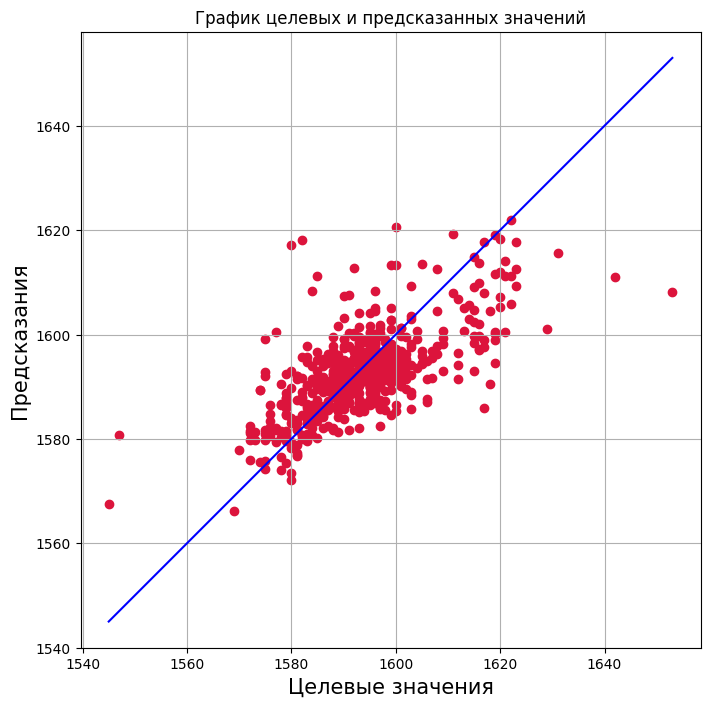

In [ ]:
# график целевых и предсказанных значений
plt.figure(figsize=(8,8))
plt.scatter(target_test, prediction_cb, c='crimson')

p1 = max(max(prediction_cb), max(target_test))
p2 = min(min(prediction_cb), min(target_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Целевые значения', fontsize=15)
plt.ylabel('Предсказания', fontsize=15)
plt.axis('equal')
plt.title('График целевых и предсказанных значений')
plt.grid()
plt.show()

На графике видно, что точки распологаются близко к центральной линии, однако они точны не на 100%

### Анализ важности факторов 

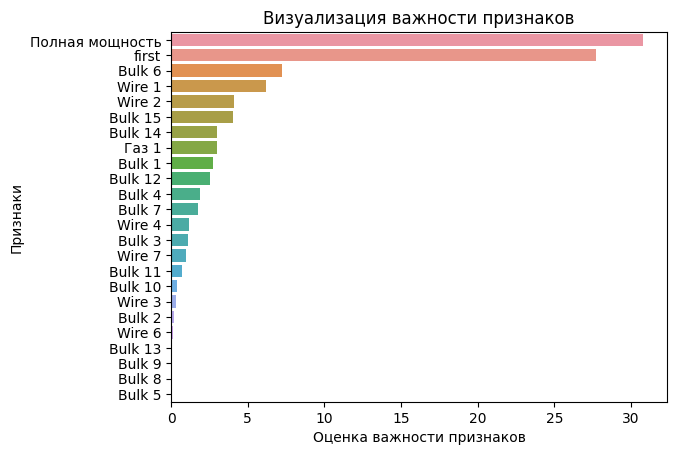

In [ ]:

def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=features_test.columns).sort_values(ascending=False)

    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')

chart_feature_imp(cb_model)

**Вывод:**

По данным инструмента feature_importances_ наиболее важнымии признаками для предсказания температуры СТАЛИ являются - Полная мощность и первая измеренная темепература

## Вывод

Таким образом, были проанализированы предоставленные данные, сделаны выводы, обработаны пропуски в данных, выбраны признаки для обучения модели, добавлены новые признаки.

Далее были выбраны подходящие модели для обучения, применен перебор наилучших гиперпараметров (с кроссвалидацией) и получены значения качества модели - MAE

Модель с наилучшим значением качества (CatBoostRegressor) была применена на тестовой выборке и итоговое значение качества модели MAE = 6.2589. Данные с полученными значениями были визуализиорованы.

Цель проекта - предсказание температры плавления стали с метрикой качества MAE < 6.8 была достигнуто 

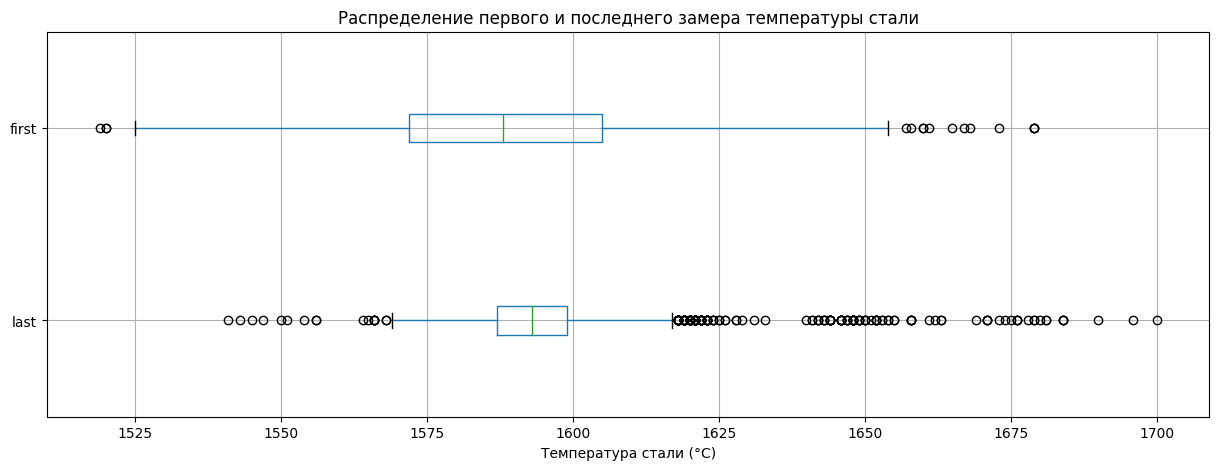

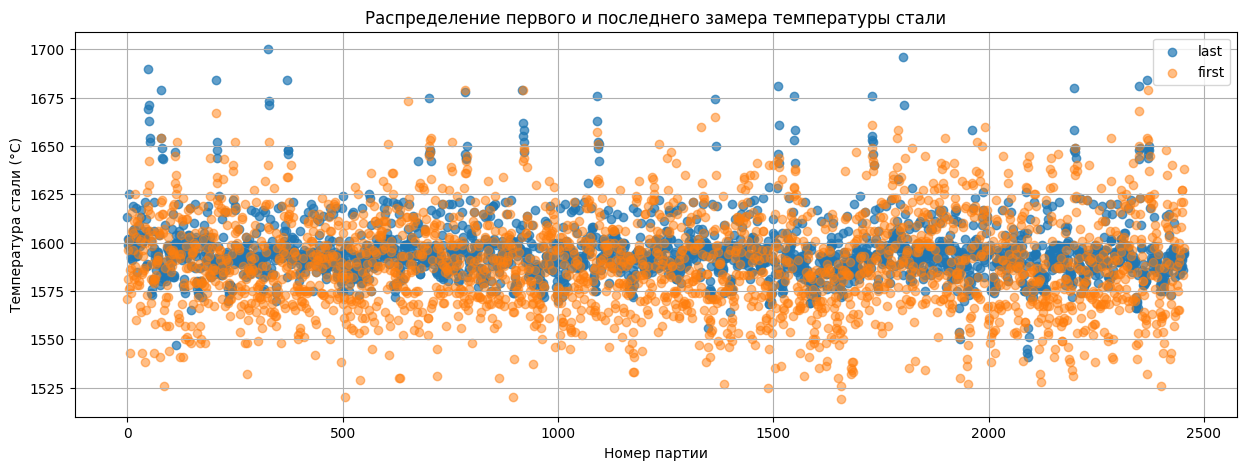

In [ ]:
data_temp_gr.boxplot(column = ['last', 'first'], vert=False, figsize = (15,5))
plt.title('Распределение первого и последнего замера температуры стали')
plt.xlabel('Температура стали (°C)');

fig=plt.subplots(figsize = (15,5))
plt.scatter(x=data_temp_gr.index, y=data_temp_gr['last'], alpha=0.7, label='last')
plt.scatter(x=data_temp_gr.index, y=data_temp_gr['first'], alpha=0.5, label='first')
plt.grid()
plt.title('Распределение первого и последнего замера температуры стали')
plt.xlabel('Номер партии')
plt.ylabel('Температура стали (°C)')
plt.legend();

По графикам видно, что большинство значений первичного измерение температуры стали находится в промежутке между 1550 и 1625 °C, остальные значеня малочислены. Также можно обратить внимание на то, что первичная температура чаще имеет более низкую температуру, чем итоговое измерение температуры, кроме того значения более рассеяны и имеет большие промежутки между точками.

Последнее измерение температуры более концентрированное (имеет близкие друг к другу значения темепературы) и показатели находятся в диапазоне между 1575 и 1625 °C (большая часть значений температуры в районе 1580 - 1600 °C).

Таким образом, действительно, можно отследить значения выбивающиеся из общей массы и проанализировать эти партии - построить модели и гипотезы о том, что отличает данные партии от остальных

## ОТЧЁТ

**Задача**
Помочь компании по имеющимся данным предсказывать температуру нагрева стали на этапе ее обработки для уменьшения потребления электроэнергии 

1. Все пункты плана по решению задачи были выполнены

* Были проанализированы и подготовлены данные - Обработаны пропуски, созданы дополнительные признаки, удалены данные, помешающие обучению модели, составлена общая таблица данных.

* Была произведена подготовка к обучению - выделение целевого признака (последний замер температуры), разделение данных на features и target. 
Признаки были проверены на мультиколлинеарность до моделирования и удалены те признаки, которые имели высокую корреляцию между собой, а так же данные с нулевыми значениями (Активная мощность, Реактивная мощность, Wire 5, Wire 8)
* Выбраны три модели для обучения (Линейная регрессия, Случайный лес, Кэтбуст)
* Данные модели применены на обучающей выборке и выбрана лучшая. 
* Лучшая модель применена на тестовой выборке и оценена точность прогноза 



2. Трудности при исполнении проекта: наличие пропусков в целевых данных

Решение: удаление партий в которых присутствуют пропуски

3. Ключевые шаги в решении задачи: анализ предоставленных данных, очистка от лишнего, приведение в единую таблицу, выбор подходящих для обучения моделей, обучение, подбор гиперпараметров, улучшение метрик качества, тестирование и получение конечного результата

4. Итоговая модель: CatBoostRegressor

Параметры наилучшей модели - {'depth': 4, 'iterations': 200, 'learning_rate': 0.1} С использованием GridSearchCV

random_state = 130223

MAE на тестовой выборке =  6.2589

5. Важные признаки для обучения модели: с помощью инструмента feature_importances_ было выявлено, что одними из самых важных признаков для прогноза стали - Полная мощность и первое измерение температуры. Полная мощность была рассчитана путем выисления корня из сумм квадратов Активной и Реактивно мощностей. А первое измерение температуры, как и последнее было отобрано путем агригации данных по партиям.

6. Рекомендации для улучшения модели - как обсуждалось ранее, можно выявить аномальные значения температур и сделать акцент на анализ этих партий - какие иные действия были предприняты при производстве, какие пропорции элементов были использованы, какие бригады выполняли изготовление. 

Для улучшения модели машинного обучения можно попробовать повторно пересмотреть признаки и убрать те, что имели меньшую значимость при обучении

